In [18]:
import matplotlib.pyplot as plt
import time
from time import perf_counter_ns
import math

from cucim.skimage.feature import peak_local_max
import numba
import numpy as np
import cupy as cp
from numba import cuda, vectorize, njit
from numba.cuda.random import create_xoroshiro128p_states, xoroshiro128p_normal_float32, xoroshiro128p_uniform_float32
import importlib
import gpu_random

importlib.reload(gpu_random)

import gpu_random

# Constants & Utilities

In [3]:
nwires = 1664  # Number of TPC wires (dimension along the beam)
nticks = 3400  # Number of TPC time ticks (dimension transverse to the beam)

# geometry info for drawing lines back to target
target = 11000  # Distance to target, cm
dwire = 0.3  # Distance between wires, cm/wire
dtick = 0.05  # Distance between ticks, cm/tick
length_wires = nwires * dwire  # 449.2 cm
length_ticks = nticks * dtick  # 170 cm
# Target is a cylinder, 71.1 cm long with radius 0.51 cm, see section II B of
# https://journals-aps-org.proxy.libraries.rutgers.edu/prd/pdf/10.1103/PhysRevD.79.072002
# We use slightly larger radius to account for various inaccuracies.
# todo revisit these increases
y_min = 82  # Lower y limit, cm
y_max = 88  # Upper y limit, cm
length_target = 74  # cm

In [4]:
# calculation of the maximum distance between the points on the front side for any point on the back side
# https://www.desmos.com/calculator/gncrncjxhi

# nopython jit so that it can be used on CPU & as a device function
@njit(nogil=True)
def intercept(y_end: float, back: bool, y: float) -> float:
    """
    For a given height (cm) on far side of the detector, calculate the point on the close side that is on a line between
    the far point and one of four boundary points of the target.
    This function is called l in the Desmos: https://www.desmos.com/calculator/gncrncjxhi.
    :param y_end: the y coordinate of the end point in cm, `f` in Desmos
    :param back: true if the point is the back of the target, false for the front point, `b` Desmos
    :param y: y_min or y_max in cm, `i` in Desmos
    """
    back_length = length_target if back else 0
    slope = (y_end - y) / (target + length_wires + back_length)
    return slope * (target + back_length) + y


@cuda.jit
def intercept_kern(y_end: cp.ndarray, back: cp.ndarray, y: float, out: cp.ndarray):
    """
    Calculate the intercept for many `y_end`s at once.
    """
    idx = cuda.grid(1)
    if idx < len(y_end):
        out[idx] = intercept(y_end[idx], back[idx], y)


def delta_ticks(y_end: float) -> float:
    """
    For a given height (cm) on the far side of the detector, calculate how many ticks are between the points on the
    close side of the detector on lines from that far side point to the top/bottom of the target.
    This function is the last equation in the Desmos, l(...1)-l(...0): https://www.desmos.com/calculator/gncrncjxhi.
    :param y_end: the y coordinate of the end point in cm, `f` in Desmos
    """
    max_intercept = intercept(y_end, y_end > y_max, y_max)
    min_intercept = intercept(y_end, y_end < y_min, y_min)
    delta_ticks_cm = max_intercept - min_intercept
    return math.ceil(delta_ticks_cm / dtick)


# the largest separation will either be at the very top or very bottom tick,
# or a point between y_min and y_max (all such points have same separation)
tick_separation = max(delta_ticks(y_end) for y_end in [0, y_min + 1, length_ticks])


# if tick_separation <= 1024, can fit each row into one block
# if tick_separation <= ~25, can fit entire track sum on gpu
print(f'tick_separation = {tick_separation}')

tick_separation = 6


In [5]:
# taken from `standard_detsim_sbnd.fcl`
noise_model = {
    "CohExpNorm": 3.67206,
    "CohExpOffset": 2.32098e-1,
    "CohExpWidth": 3.39581,
    "CohGausMean": [
        3.55622e1,
        6.63823e-2,
        1.162e2,
        1.739e2,
        2.898e2
    ],
    "CohGausNorm": [
        6.88535,
        5.21692e-1,
        2.00001,
        2.0363,
        2.00003
    ],
    "CohGausSigma": [
        1.75992e1,
        3.16607e2,
        3.68024e-1,
        3.26335e-1,
        5.1472e-2
    ],
    "CohNoiseArrayPoints": 1000,
    "EffectiveNBits": 1.06e1,
    "EnableCoherentNoise": False,
    "EnableGaussianNoise": False,
    "EnableMicroBooNoise": True,
    "EnableWhiteNoise": False,
    "GausMeanU": [
        630,
        640,
        730
    ],
    "GausMeanV": [
        130,
        330,
        430
    ],
    "GausMeanZ": [
        34
    ],
    "GausNormU": [
        30,
        -3,
        15
    ],
    "GausNormV": [
        30,
        40,
        15
    ],
    "GausNormZ": [
        3
    ],
    "GausSigmaU": [
        5e-1,
        5e-1,
        5e-1
    ],
    "GausSigmaV": [
        5e-1,
        2,
        5e-1
    ],
    "GausSigmaZ": [
        5
    ],
    "IncludeJumpers": False,
    "JumperCapacitance": 5,
    "LogLevel": 0,
    "NChannelsPerCoherentGroup": [
        40,
        40,
        48
    ],
    "NoiseArrayPoints": 1000,
    "NoiseFunctionParameters": [
        1.19777e1,
        170000.0,
        4.93692e3,
        1.03438e3,
        2.33306e2,
        1.36605,
        4.08741,
        3.5e-3,
        9596.0
    ],
    "UFirstJumper": 420,
    "ULastJumper": 1568,
    "VFirstJumper": 417,
    "VLastJumper": 1565,
    "WhiteNoiseU": 1.6,
    "WhiteNoiseV": 1.6,
    "WhiteNoiseZ": 1.6,
    "service_provider": "SBNDuBooNEDataDrivenNoiseService"
}

In [6]:
def time_function(f, warm_up: int = 5, iters: int = 100):
    # warm up
    print('warming up')
    for i in range(warm_up):
        f()
    cuda.synchronize()

    print('timing...')
    timing = np.empty(iters)
    for i in range(iters):
        start = perf_counter_ns()
        ret = f()
        # cuda.synchronize()
        stop = perf_counter_ns()
        timing[i] = stop - start
    timing *= 1e-6
    print(f"Elapsed time: {timing.mean():.3f} ± {timing.std():.3f} ms")
    return ret

# Noise generation

In [9]:
def wld(x):
    return 0.395 + 0.001304 * x


# from print out sbndcode values
# wirelength = 2 * halfLength
wirelength = 400
noise_model['NoiseFunctionParameters'][6] = wld(wirelength)
nfp0, nfp1, nfp2, nfp3, nfp4, nfp5, nfp6, nfp7, nfp8 = noise_model['NoiseFunctionParameters']


@cp.fuse
def pfn_f1_gpu(x):
    term1 = nfp0 * 1 / (x / 1000 * nfp8 / 2)
    term2 = nfp1 * cp.power(cp.e, (-0.5 * cp.power((((x / 1000 * nfp8 / 2) - nfp2) / nfp3), 2)))
    term3 = cp.power(cp.e, (-0.5 * pow(x / 1000 * nfp8 / (2 * nfp4), nfp5)))
    return (term1 + (term2 * term3) * nfp6) + nfp7


@cp.fuse
def calc_noise_frequency_along_wire(tick, poisson_number, phase):
    pfnf1val = pfn_f1_gpu((tick + 0.5) * binwidth)
    pval = pfnf1val * poisson_number
    return pval * cp.cos(phase) + 1j * pval * cp.sin(phase)


# Drift is 1.3 ms (2600 ticks), and we save 0.20 ms (400 ticks) of pre- and post-drift
number_time_samples = 3400

# sigs = np.zeros(nwires, dtype=float)
ntick = 4096  # where did 4096 come frome? seems like nowhere
# ntick = number_time_samples * 2
# samplerate = 500
clock_freq = 1e8
samplerate = 1000 * (1 / clock_freq)
binwidth = 1 / (ntick * samplerate * 1e-6)


def gen_noise(rng: cp.random.RandomState):
    """Generate noise for an event.

    This is the starting point of the simulation.

    :return: A 2d cp.ndarray with shape (nwires, nticks)
    """
    # from sbndcode
    poisson_mu = 3.30762
    # generate the poisson random numbers
    poisson_random = rng.poisson(poisson_mu, size=(nwires, nticks)) / poisson_mu

    # generate the random phase
    uniform_random = rng.uniform(0, 2 * math.pi, (nwires, nticks), dtype=np.float32)

    # generate tick number for each wire: (0, 1, 2, 3, 4, 5, ..., nticks - 1) copied nwires times
    ticks = cp.tile(cp.arange(nticks, dtype=np.int32), (nwires, 1))

    # calculate frequencies
    noise_d = calc_noise_frequency_along_wire(ticks, poisson_random, uniform_random)
    # kinda magic constant, but basically chosen to take the range to ±6 ADCs
    # todo figure out what the conversion should actually be
    noise_d *= 25000

    # inverse fourier transform each wire to get the noise
    noise_d = cp.array([cp.real(cp.fft.ifft(channel_freqs)) for channel_freqs in noise_d], dtype=np.float32)
    return noise_d

In [10]:
rng = cp.random.RandomState()
noise = gen_noise(rng)
# noise = time_function(lambda: gen_noise(rng), warm_up=1, iters=1)
noise.shape

(1664, 3400)

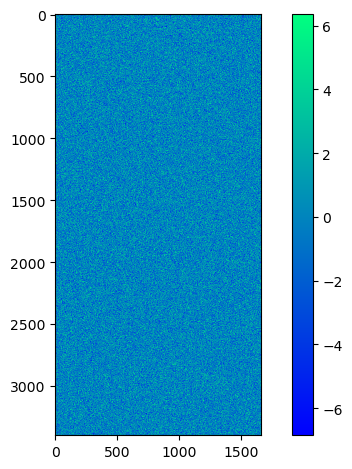

In [11]:
plt.imshow(noise.get().T, interpolation='none', cmap='winter')
plt.colorbar()
plt.tight_layout()
plt.show()

In [46]:
@cuda.jit
def shuffle_noise_kern(noise, new_noise, indices, roll_amounts):
    w, t = cuda.grid(2)
    if w < nwires and t < nticks:
        new_w = indices[w]
        new_t = (t + roll_amounts[w]) % nticks
        new_noise[new_w, new_t] = noise[w, t]

def shuffle_noise(noise):
    new_noise = cp.empty_like(noise)
    # wire at noise[0] goes into new_noise[indices[0]]
    indices = cp.arange(0, nwires)
    cp.random.shuffle(indices)
    roll_amounts = cp.random.randint(0, nwires, size=nwires)
    threads = (16, 32)
    blocks = tuple(math.ceil(noise.shape[axis] / threads[axis]) for axis in [0, 1])
    shuffle_noise_kern[blocks, threads](noise, new_noise, indices, roll_amounts)
    return new_noise

In [55]:
time_function(lambda: shuffle_noise(noise))

warming up
timing...
Elapsed time: 1.166 ± 0.063 ms


array([[ 1.46118588,  0.84528045, -0.3533568 , ..., -1.82384777,
        -0.42109507,  1.94153366],
       [ 0.97731826,  0.82705519, -1.9493835 , ..., -1.08415806,
         0.39866505,  0.96040355],
       [-0.18142533,  0.31980427, -0.24884089, ...,  0.66314528,
         0.58043963,  1.09228472],
       ...,
       [-0.57385586, -0.96889344, -1.18491992, ...,  0.97337756,
        -0.83910194,  0.65667306],
       [-0.58844778,  0.48738553,  0.69265065, ...,  1.45352774,
         0.77743732, -0.47521909],
       [-0.04282938, -1.23387228, -0.80919471, ...,  0.3082073 ,
        -0.21956686, -0.51126313]])

In [37]:
# warm up
print('warming up')
for i in range(5):
    shuffle_noise(noise)
cuda.synchronize()

print('timing...')
timing = np.empty((6, 100))
for i in range(100):
    start = perf_counter_ns()
    ignore, sub_timings = shuffle_noise(noise)
    # cuda.synchronize()
    stop = perf_counter_ns()
    timing[0, i] = stop - start
    for t, sub_timing in enumerate(sub_timings):
        timing[t + 1, i] = sub_timing
timing *= 1e-6
print(f"             Elapsed time: {timing[0].mean():.3f} ± {timing[0].std():.3f} ms")
print(f"  Elapsed time (cp.empty): {timing[1].mean():.3f} ± {timing[1].std():.3f} ms")
print(f" Elapsed time (np.arange): {timing[2].mean():.3f} ± {timing[2].std():.3f} ms")
print(f"Elapsed time (np.shuffle): {timing[3].mean():.3f} ± {timing[3].std():.3f} ms")
print(f"Elapsed time (np.randint): {timing[4].mean():.3f} ± {timing[4].std():.3f} ms")
print(f"      Elapsed time (roll): {timing[5].mean():.3f} ± {timing[5].std():.3f} ms")

warming up
timing...
              Elapsed time: 77.344 ± 0.168 ms
   Elapsed time (cp.empty): 0.009 ± 0.001 ms
  Elapsed time (np.arange): 0.004 ± 0.000 ms
 Elapsed time (np.shuffle): 0.024 ± 0.001 ms
 Elapsed time (np.randint): 0.035 ± 0.026 ms
       Elapsed time (roll): 77.269 ± 0.163 ms
       Elapsed time (copy): 0.000 ± 0.000 ms


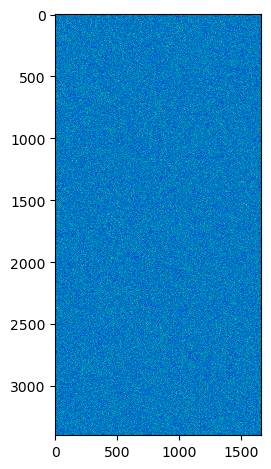

In [29]:
shuffled_noise = shuffle_noise(noise)

plt.imshow(shuffled_noise.get().T, interpolation='none', cmap='winter')
# plt.colorbar()
plt.tight_layout()
plt.show()

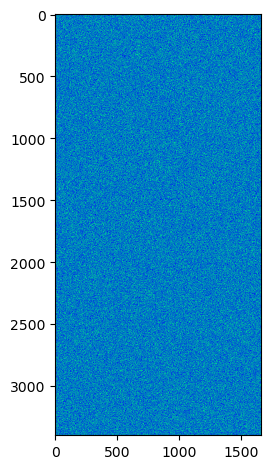

In [12]:
plt.imshow(noise.get().T, interpolation='none', cmap='winter')
# plt.colorbar()
plt.tight_layout()
plt.show()

# Track generation

In [12]:
DL = 3.74  # cm²/s (longitudinal electron diffusion coeff)
DL = DL * 1e-6  # cm²/μs (longitudinal electron diffusion coeff)
v_d = 1.076  # mm/μs (drift velocity)
v_d = v_d * 1e-1  # cm/μs (drift velocity)
sigma_t0_2 = 1.98  # μs² (time width)
E = 273.9  # V/cm (E field)

# from https://lar.bnl.gov/properties/
energy_per_electron = 23.6  # eV/e⁻ pair
# from https://arxiv.org/pdf/1802.08709.pdf or https://arxiv.org/pdf/1804.02583.pdf
electrons_per_adc = 187  # e⁻/ADC
survival_probability = 0.6980  # % (survive recombination)
dEdx_mean = 2.1173  # MeV/cm
# dEdx_mean = dEdx_mean * 1e6 # eV/cm
z = 1  # % (mCP charge fraction)
dEdx_mean *= z ** 2  # scale based on charge
# print("dEdx_mean = ", dEdx_mean)

width = 200  # cm (x)
height = 400  # cm (y)
length = 500  # cm (beam direction, z)
n_steps = nwires  # number

# magic number to get shape of landau distribution right
width_factor = 10
energy_loss_cutoff = 1e5

In [13]:
rng = np.random.default_rng()


@cuda.jit
def get_start_end_pairs_gpu(rng_states, y0s, y1s):
    idx = cuda.grid(1)
    if idx < len(y0s):
        y1 = gpu_random.uniform(rng_states, idx, 0, nticks)
        y1_cm = y1 * dtick
        y0_min_cm = intercept(y1_cm, y1_cm < y_min, y_min)
        y0_max_cm = intercept(y1_cm, y1_cm > y_max, y_max)
        y0_min = math.floor(y0_min_cm / dtick)
        y0_max = math.ceil(y0_max_cm / dtick)
        y0 = gpu_random.uniform(rng_states, idx, y0_min, y0_max)
        y0s[idx] = y0
        y1s[idx] = y1


def get_start_end_pairs(n_pairs, rng_states):
    y0 = cp.empty(n_pairs)
    y1 = cp.empty(n_pairs)
    get_start_end_pairs_gpu.forall(n_pairs)(rng_states, y0, y1)
    return y0.get(), y1.get()


rng = create_xoroshiro128p_states(1024, seed=1)
# y0, y1 = get_start_end_pair_gpu(1024, rng)
y0, y1 = get_start_end_pairs(1024, rng)
print(y0[0], y1[0])

TypingError: Failed in cuda mode pipeline (step: nopython frontend)
Internal error at resolving type of attribute "uniform" of "$24load_global.0".
module 'gpu_random' has no attribute 'uniform'
During: typing of get attribute at /tmp/ipykernel_1179854/1314837346.py (8)
Enable logging at debug level for details.

File "../../../tmp/ipykernel_1179854/1314837346.py", line 8:
<source missing, REPL/exec in use?>


In [34]:
npairs = 50_000_000
rng = create_xoroshiro128p_states(npairs, seed=1)
time_function(lambda: get_start_end_pairs(1024, rng))
# pairs = get_start_end_pairs(1000, rng)
# get_start_end_pairs(npairs, rng)

warming up
timing...
Elapsed time: 0.446 ± 0.004 ms


(array([ 363.35907742,   80.99007079, 2604.9281373 , ..., 3095.32128668,
        1518.53378451,  885.2223618 ]),
 array([ 303.15399021,    9.50804455, 2645.43020725, ..., 3156.64160252,
        1507.39289522,  851.87000632]))

In [19]:
@cp.fuse
def get_n_ionization_electrons(energy_loss: np.float32) -> cp.int32:
    """GPU vectorized function to convert energy losses into #s of electrons that get detected
    :param energy_loss: energy loss in MeV
    :return: num of electrons that make it to readout
    """
    # convert to eV, get rid of negatives, and put in an upper threshold (otherwise, the
    # long tail of the landau makes some super huge values wash everything else out)
    # todo eventually ask Mastbaum if this cutoff makes sense
    energy_loss = cp.minimum(cp.maximum(1e6 * energy_loss, 0), energy_loss_cutoff)
    # number of elections ionized
    n_electrons = energy_loss / energy_per_electron
    # number of electrons that make it to readout
    return (n_electrons * survival_probability).astype(cp.int32)


MAX_IONIZATION_ELECTRONS = int(energy_loss_cutoff / energy_per_electron * survival_probability)


@cp.fuse
def get_sigma_x(x: np.float32):
    """GPU vectorized function to convert distance to readout to Gaussian width of spread
    :param x: Distance from interaction to readout plane, cm
    :return: Gaussian width, cm
    """
    # drift time, μs
    t = x / v_d
    # equation 3.1 of https://iopscience.iop.org/article/10.1088/1748-0221/16/09/P09025/pdf
    # this is the width on the collection plane (μs)
    sigma_t = cp.sqrt(sigma_t0_2 + (2 * DL / v_d ** 2) * t)
    return sigma_t * v_d * 6  # 6 is a fudge factor


# see benchmark_n_chunks.png
CHUNKS = 128
adc_grids = 2 ** (math.ceil(math.sqrt(CHUNKS)) - 1).bit_length()
adc_blocks = math.ceil(CHUNKS / adc_grids)

# adc_blocks = 16
# adc_grids = 16
# CHUNKS = adc_grids * adc_blocks
# print(f'CHUNKS = {CHUNKS}')


@cuda.jit(fastmath=True)
def adcs_noise(y0: np.float32, y_slope: np.float32, ionization_electrons: cp.ndarray,
               sigma_xs: cp.ndarray, event_arrays: cp.ndarray, wire_random, tick_random):
    """

    :param rngs: numba cuda rng states, must be at least MAX_IONIZATION_ELECTRONS states
    :param y0: start tick
    :param y_slope: tick slope as z increases
    :param ionization_electrons: How many ionization electrons were generated at each simulation step along the detector
    :param sigma_xs: The width of the Gaussian at each sim step along the detector
    :param event_arrays: a 2d cp.ndarray, with shape (CHUNKS, nwires, nticks) to be filled. Calling this
    kernel essentially creates `CHUNKS` new event arrays, which are summed together afterwords.
    :param tick_random:
    :param wire_random:
    """
    chunk = cuda.grid(1)
    if chunk < CHUNKS:
        for idx in range(chunk, n_steps, CHUNKS):
            # todo take step size into account
            z = idx
            y = y0 + y_slope * z
            sigma_x = sigma_xs[idx]
            n_electrons = ionization_electrons[idx]
            # each ionization electron gets put to a random (wire, tick) offset
            for i in range(n_electrons):
                # todo I think both wire & tick need to be converted from cm to wire/tick
                # wire, gaussian distributed around the current wire (z)
                wire = sigma_x * wire_random[idx, i]
                # wire = sigma_x * xoroshiro128p_normal_float32(rngs, idx)
                wire += z
                wire = int(wire)

                # tick, gaussian distributed around the current tick (y) (this is kinda weird?)
                # tick = sigma_x * xoroshiro128p_normal_float32(rngs, idx)
                tick = sigma_x * tick_random[idx, i]
                # tick = tick / nticks * height
                tick += y
                # tick = tick / height * nticks
                tick = int(tick)

                # add 1 to that index if it is in the bounds of the event
                # boolean logic is much faster than branching on GPU
                cuda.atomic.add(event_arrays, (chunk, wire, tick), 0 <= wire < nwires and 0 <= tick < nticks)


def simulate_track(rng: cp.random.RandomState, event: cp.ndarray, x0: int, y0: np.float32, x1: int, y1: np.float32, event_arrays_d: cp.ndarray):
    """Simulates a mCP crossing the detector, from (x0, y0) to (x1, y1)
    :param rng: cupy rng state
    :param event: A 2d (nwires, nticks) cp.ndarray of noise
    :param x0: Start wire
    :param y0: Start tick
    :param x1: End wire
    :param y1: End tick
    :param event_arrays_d: A 3d (CHUNKS, nwires, nticks) cp.ndarray, used as CHUNKS new event arrays that the event is
    written into before being combined into `event`
    """
    start = perf_counter_ns()
    # random energy losses
    # todo the energy loss has to scale down with smaller step size, cuz this is currently using dEdx as just dE already
    energy_losses_d = gpu_random.landau_rvs(n_steps, dEdx_mean, dEdx_mean / width_factor, rng)

    cuda.synchronize()
    stop_energy_losses = perf_counter_ns()

    # get # of ionization electrons
    ionization_electrons_d = get_n_ionization_electrons(energy_losses_d)

    cuda.synchronize()
    stop_ionization_n = perf_counter_ns()

    # get sigma of normal distribution
    x_slope = (x1 - x0) / n_steps
    # distance to readout plane, cm
    xs_d = x0 + cp.arange(n_steps, dtype=np.float32) * x_slope
    sigma_xs_d = get_sigma_x(xs_d)

    cuda.synchronize()
    stop_sigmas = perf_counter_ns()

    # get individual
    y_slope = (y1 - y0) / n_steps

    # reduce
    wire_random_d = rng.normal(size=(n_steps, MAX_IONIZATION_ELECTRONS), dtype=np.float32)
    tick_random_d = rng.normal(size=(n_steps, MAX_IONIZATION_ELECTRONS), dtype=np.float32)
    event_arrays_d.fill(0)
    adcs_noise[adc_grids, adc_blocks](y0, y_slope, ionization_electrons_d, sigma_xs_d, event_arrays_d, wire_random_d, tick_random_d)

    cuda.synchronize()
    stop_adcs = perf_counter_ns()

    reduced = event_arrays_d.sum(axis=0)

    cuda.synchronize()
    stop_reduction = perf_counter_ns()

    reduced /= electrons_per_adc
    event += reduced

    cuda.synchronize()
    stop = perf_counter_ns()
    timings = [stop_energy_losses - start,
               stop_ionization_n - stop_energy_losses,
               stop_sigmas - stop_ionization_n,
               stop_adcs - stop_sigmas,
               stop_reduction - stop_adcs,
               stop - stop_reduction]
    return timings

In [22]:
noise_rng = create_xoroshiro128p_states(n_steps, 95755828)
y0, y1 = np.array([2021, 2109], dtype=np.float32)
event_arrays_d = cp.empty((CHUNKS, nwires, nticks), np.float32)

simulate_track(cp.random.RandomState(), noise, 0, y0, n_steps - 1, y1, event_arrays_d)
# time_function(lambda: add_track(noise, x0, y0, x1, y1, noise_rng))

/home/aschwart/anaconda3/envs/mq/lib/python3.10/site-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 52 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/home/aschwart/anaconda3/envs/mq/lib/python3.10/site-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 16 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


[646274419, 4750682, 4995887, 335525759, 8239371, 3056306]

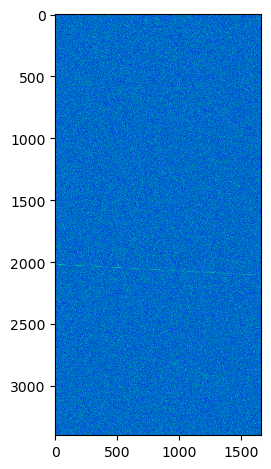

In [23]:
plt.imshow(noise.get().T, interpolation='none', cmap='winter')
# plt.colorbar()
# plt.axis('off')
plt.tight_layout()
plt.show()

# Track finding

In [24]:
# implementation from paper cited in `skimage.draw.line_aa`:
# Listing 16 of http://members.chello.at/easyfilter/Bresenham.pdf
@cuda.jit(device=True)
def sum_along_line(x0, y0, x1, y1, event, aa, normalize):
    total = 0
    npoints = 0
    dx = abs(x1 - x0)
    sx = 1 if x0 < x1 else -1
    dy = abs(y1 - y0)
    sy = 1 if y0 < y1 else -1
    err = dx - dy
    ed = 1 if dx + dy == 0 else math.sqrt(dx ** 2 + dy ** 2)
    while True:
        # img[x0, y0] = 255 * (1 - abs(err - dx + dy) / ed)
        # 1 if aa is False, if aa is True (= 1) then subtract the antialiasing amount (multiplication should be faster than branching esp on GPU)
        aa_mult = 1 - aa * abs(err - dx + dy) / ed
        total += aa_mult * event[x0, y0]
        npoints += aa_mult
        e2 = err
        x2 = x0
        if 2 * e2 >= -dx:
            if x0 == x1:
                break
            if e2 + dy < ed:
                # img[x0, y0 + sy] = 255 * (1 - (e2 + dy) / ed)
                aa_mult = 1 - aa * (e2 + dy) / ed
                total += aa_mult * event[x0, y0 + sy]
                npoints += aa_mult
            err -= dy
            x0 += sx
        if 2 * e2 <= dy:
            if y0 == y1:
                break
            if dx - e2 < ed:
                # img[x2 + sx, y0] = 255 * (1 - (dx - e2) / ed)
                aa_mult = 1 - aa * (dx - e2) / ed
                total += aa_mult * event[x2 + sy, y0]
                npoints += aa_mult
            err += dx
            y0 += sy
    return total / npoints if normalize else total


# 1024 is the max # of threads per block
threads = 1024
# how many end tick values each thread is able to calculate
ticks_per_block = threads // tick_separation
# number of blocks
blocks = math.ceil(nticks / ticks_per_block)

y_min_t = y_min / dtick


@cuda.jit
def make_tracks_gpu2(event, sums, aa, normalize):
    # cuda.grid(1) == cuda.threadIdx + cuda.blockIdx.x * cuda.blockDim.x
    tid = cuda.threadIdx.x
    if tid < ticks_per_block * tick_separation:
        end = tid // tick_separation + cuda.blockIdx.x * ticks_per_block
        start = y_min_t + (abs(target) / (abs(target) + length_wires)) * (end - y_min_t)
        start = round(start) + tid % tick_separation
        if start < nticks:
            sums[start, end] = sum_along_line(0, start, nwires - 1, end, event, aa, normalize)


def track_sums2(event):
    sums_d = cp.full((nticks, nticks), -1, np.float32)
    # sums_d = cp.zeros(nticks * 10)
    make_tracks_gpu2[blocks, threads](event, sums_d, True, True)
    return sums_d


@cuda.jit
def make_tracks_gpu(nticks, event, sums, aa, normalize):
    # start and end tick
    start, end = cuda.grid(2)

    if start < nticks and end < nticks:
        slope = ((end - start) * dtick) / (nwires * dwire)
        # y position at x=target (above/below target)
        ypos = (slope * target) + (start * dtick)

        if y_min < ypos < y_max:
            sums[start, end] = sum_along_line(0, start, nwires - 1, end, event, aa, normalize)


def track_sums(event, aa=True, normalize=True):
    sums_d = cp.full((nticks, nticks), -1.0)
    # 32x32 is 1024 threads per block, which is the max allowed
    threads = (32, 32)
    blocks = tuple(math.ceil(nticks / n) for n in threads)
    make_tracks_gpu[blocks, threads](nticks, event, sums_d, aa, normalize)
    return sums_d


sums_d = track_sums2(noise)
sums = sums_d.get()

/home/aschwart/anaconda3/envs/mq/lib/python3.10/site-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 20 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


In [25]:
time_function(lambda: track_sums2(noise))

warming up
timing...
Elapsed time: 19.867 ± 1.957 ms


array([[-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       ...,
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.]], dtype=float32)

#### Find Peaks

In [ ]:
@cuda.jit
def max_filter1d():
    """
    input=image
    size=3
    axis=0,1
    output=output
    mode=4
    cval=0.0
    origin=0

    """
    pass


def maximum_filter(image, footprint):
    """
    image
    size=None
    footprint
    structure=None
    output=None
    mode='constant'=4
    cval=0.0
    origin=0
    minimum=0
    """
    size = footprint.shape
    output = cp.zeros(image.shape, dtype=image.dtype.name)
    for i in range(2):
        max_filter2d(image, size[i], i, output, 'constant', 0.0, 0)
        input = output
    pass


def get_peak_mask(image, footprint, threshold):
    output = cp.zeros(image.shape, dtype=image.dtype.name)
    pass


def peak_local_max_gpu(image, num_peaks, min_dist):
    coordinates_d = cp.empty((num_peaks, 2), dtype=int)
    border_width = min_dist
    threshold = cp.min(image)
    size = 2 * min_dist + 1
    footprint = cp.ones((size, size), dtype=bool)
    mask = get_peak_mask(image, footprint, threshold)
    mask = exclude_border(mask, border_width)
    coordinates_d = get_high_intensity_peaks(image, mask, num_peaks, np.inf)

In [32]:
time_function(lambda: peak_local_max(sums_d, min_distance=1, num_peaks=1))

warming up
timing...
Elapsed time: 10 ± 1 ms


array([[2720, 2109]])

True start/end points:
2021.0 2109.0
time.time() - start = 0.010984659194946289
Found peaks (local max):
[[2057 2076]]


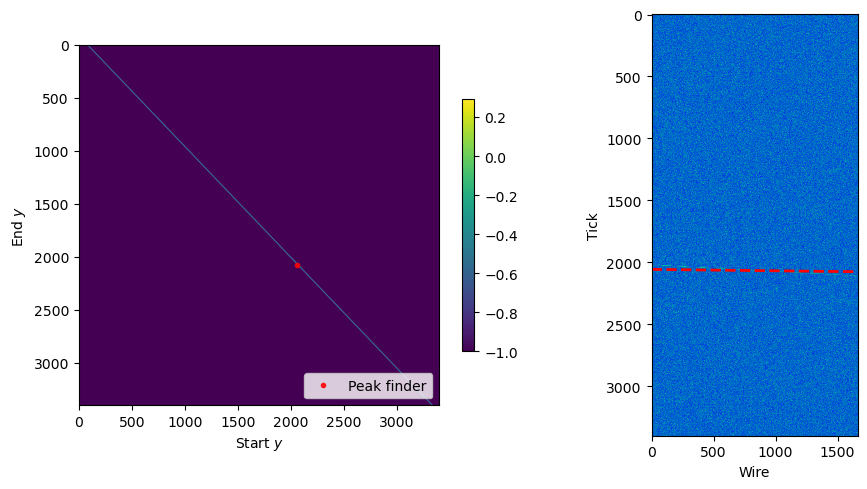

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

### Draw the 2D plot
im0 = ax[0].imshow(sums.T)
# ax[0].plot(*list(truth.T), 'o', c='blue', alpha=0.75, label='Truth')
plt.colorbar(im0, shrink=0.6, ax=ax[0], cmap='winter')

# Also print out the start/end of true tracks
print('True start/end points:')
print(y0 ,y1)

### Find peaks in 2D using various scikit-image tools

# Blob finder (disables as it sometimes finds LOTS of blobs)
#peaks = blob_log(h, min_sigma=2, max_sigma=2, num_sigma=2, threshold=0.1)
#peaks = peaks[:,:2]
#ax[0].plot(*list(peaks.T), 'o', c='green', alpha=0.75, label='Blob finder')
#print('Found peaks (blob):')
#print(peaks)

# Local peak finder (given true number of tracks!)
start = time.time()
peaks2 = peak_local_max(sums_d, min_distance=1, num_peaks=1).get()
print(f'time.time() - start = {time.time() - start}')
ax[0].plot(*list(peaks2.T), '.', c='red', alpha=0.85, label='Peak finder')
print('Found peaks (local max):')
print(peaks2)

ax[0].set_xlabel('Start $y$')
ax[0].set_ylabel('End $y$')
ax[0].legend(loc='lower right')

### Draw the true and found lines
# downsampled = np.empty((event.shape[0] // 4, event.shape[1]))
# for (i, row) in enumerate(downsampled):
#     downsampled[i] = np.sum(np.array([event[4 * i + j] for j in range(0, 4)]), axis=0)
# downsampled = downsample(event, downsample=True)
im1 = ax[1].imshow(noise.get().T, interpolation='none', cmap='winter')

# plt.colorbar(im1, shrink=0.6, ax=ax[1])

# Truth, shifted vertically a bit
# for i, (s, e) in enumerate(truth):
#     ax[1].axline((0, s / 4), (nwires - 1, e / 4), ls='--', c='blue', lw=2, label='Truth')

# Found, shifted vertically a bit
for i, (s, e) in enumerate(peaks2):
    ax[1].axline((0, s), (nwires - 1, e), ls='--', c='red', lw=2, label='Peak finder')

ax[1].set_xlabel('Wire')
ax[1].set_ylabel('Tick')
# ax[1].set_xlim(0, nwires)
# ax[1].set_ylim(0, nticks)
# ax[1].axis('off')

plt.tight_layout()
plt.savefig('trk_mcp.png', dpi=1000)
plt.show()

In [19]:
# Need to: pip install --upgrade cuda-python

from cuda.cuda import CUdevice_attribute, cuDeviceGetAttribute, cuDeviceGetName, cuInit

# Initialize CUDA Driver API
(err,) = cuInit(0)

# Get attributes
err, DEVICE_NAME = cuDeviceGetName(128, 0)
DEVICE_NAME = DEVICE_NAME.decode("ascii").replace("\x00", "")

err, MAX_THREADS_PER_BLOCK = cuDeviceGetAttribute(
    CUdevice_attribute.CU_DEVICE_ATTRIBUTE_MAX_THREADS_PER_BLOCK, 0
)
err, MAX_BLOCK_DIM_X = cuDeviceGetAttribute(
    CUdevice_attribute.CU_DEVICE_ATTRIBUTE_MAX_BLOCK_DIM_X, 0
)
err, MAX_GRID_DIM_X = cuDeviceGetAttribute(
    CUdevice_attribute.CU_DEVICE_ATTRIBUTE_MAX_GRID_DIM_X, 0
)
err, SMs = cuDeviceGetAttribute(
    CUdevice_attribute.CU_DEVICE_ATTRIBUTE_MULTIPROCESSOR_COUNT, 0
)

print(f"Device Name: {DEVICE_NAME}")
print(f"Maximum number of multiprocessors: {SMs}")
print(f"Maximum number of threads per block: {MAX_THREADS_PER_BLOCK:10}")
print(f"Maximum number of blocks per grid:   {MAX_BLOCK_DIM_X:10}")
print(f"Maximum number of threads per grid:  {MAX_GRID_DIM_X:10}")

ModuleNotFoundError: No module named 'cuda'

In [20]:
cuda.detect()

Found 4 CUDA devices
id 0    b'NVIDIA GeForce RTX 2080 Ti'                              [SUPPORTED]
                      Compute Capability: 7.5
                           PCI Device ID: 0
                              PCI Bus ID: 23
                                    UUID: GPU-88ed6d70-2ca8-8dcf-18be-4a81eac524c3
                                Watchdog: Disabled
             FP32/FP64 Performance Ratio: 32
id 1    b'NVIDIA GeForce RTX 2080 Ti'                              [SUPPORTED]
                      Compute Capability: 7.5
                           PCI Device ID: 0
                              PCI Bus ID: 101
                                    UUID: GPU-3db41f89-cacf-c73a-96ff-a73ffb68d7da
                                Watchdog: Disabled
             FP32/FP64 Performance Ratio: 32
id 2    b'NVIDIA GeForce RTX 2080 Ti'                              [SUPPORTED]
                      Compute Capability: 7.5
                           PCI Device ID: 0
                       

True

In [21]:
cp.__version__

'11.6.0'

Elapsed time CPU: 358 ± 0 ms
Elapsed time naive: 10 ± 0 ms


In [1]:
len("84578362066519453228012335237799169385471358989286758820043296973108396279613142626322527143629151211500821061344600023455387741440447212937698952647952281423168401022728364409407800294244352")

191